# Evaluation of SSL methods

In this session we are going to implement the following evaluation modalities of SSL methods:
- kNN classifier
- linear probe
- MLP

We are going to use the ImageNet pretrained model of pytorch as pretrained model and test their performance of CIFAR10 (as we have already done in the CNN lab classes before in the course).

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np

import torch.nn as nn
import torch.optim as optim

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# TODO prova a cercare vero modello pretrained self supervised (su torchvision) e cercare di adattarlo su ImageNet
# Tabella con mia rete, from scratch, fine tuning supervised, e poi self supervised KNN, linear probing, mlp e finetuning

device = 'cuda'

# train and test functions
def train(epochs, trainloader, net, optimizer, criterion, scheduler=None):
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i + 1) % 500 == 0:    # print every 5000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
                running_loss = 0.0
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(running_loss)
            else:
                scheduler.step()
    print('Finished Training')

def test(testloader, net):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, label = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# train resnet18 from scratch
resnet18 = models.resnet18()
resnet18.fc = nn.Linear(512, 10)
resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9)
train(30, trainloader, resnet18, optimizer, criterion)
test(testloader, resnet18)

[1,   500] loss: 1.820
[2,   500] loss: 1.397
[3,   500] loss: 1.180
[4,   500] loss: 1.050
[5,   500] loss: 0.961
[6,   500] loss: 0.899
[7,   500] loss: 0.841
[8,   500] loss: 0.793
[9,   500] loss: 0.737
[10,   500] loss: 0.713
[11,   500] loss: 0.696
[12,   500] loss: 0.658
[13,   500] loss: 0.636
[14,   500] loss: 0.612
[15,   500] loss: 0.590
[16,   500] loss: 0.593
[17,   500] loss: 0.569
[18,   500] loss: 0.547
[19,   500] loss: 0.529
[20,   500] loss: 0.507
[21,   500] loss: 0.506
[22,   500] loss: 0.482
[23,   500] loss: 0.481
[24,   500] loss: 0.463
[25,   500] loss: 0.459
[26,   500] loss: 0.446
[27,   500] loss: 0.434
[28,   500] loss: 0.427
[29,   500] loss: 0.412
[30,   500] loss: 0.404
Finished Training
Accuracy of the network on the 10000 test images: 80 %


In [ ]:
torch.save(resnet18.state_dict(), './resnet18.pth')

## Exercise 0

Create a linear probe on CIFAR10 using the pretrained model of torchvision, models.resnet18(pretrained=True).

Keep attention to set the model in evaluation mode with model.eval() during the training of the linear layer, since all the layers of the pretrained model should be used in eval mode (eg the batch norm/dropout layers, if present).

In [ ]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)

for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-04)

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.to(device)
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        losses.append(loss.item())
    return np.mean(losses)

def test(model, device, test_loader, val=False):
    model.to(device)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion_test(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    mode = "Val" if val else "Test"
    print('\{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        mode,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc = correct / len(test_loader.dataset)
    return test_loss, test_acc

In [ ]:
# the main loop
train_losses = []

model.eval()
for epoch in range(1, epochs + 1):
    train_loss = train(model, 'cuda', trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, 'cuda', testloader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.521826
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.022698
\Test set: Average loss: 2.0575, Accuracy: 2774/10000 (28%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.139879
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.115050
\Test set: Average loss: 1.9121, Accuracy: 3303/10000 (33%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.970486
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.633331
\Test set: Average loss: 1.8503, Accuracy: 3552/10000 (36%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.728005
Train Epoch: 4 [32000/50000 (64%)]	Loss: 2.046372
\Test set: Average loss: 1.8314, Accuracy: 3641/10000 (36%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.743379
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.631627
\Test set: Average loss: 1.8055, Accuracy: 3774/10000 (38%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.745518
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.695895
\Test set: Average loss: 1.7768, Accuracy: 3833/10000 (38%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.893304
Train Epoch: 7 [320

In [ ]:
# with resnet18 from scratch
resnet18.fc = nn.Linear(512, 10)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc.weight.requires_grad = True
resnet18.fc.bias.requires_grad = True

batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-04)

train_losses = []

resnet18.eval()
for epoch in range(1, epochs + 1):
    train_loss = train(resnet18, 'cuda', trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(resnet18, 'cuda', testloader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.370220
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.422886
\Test set: Average loss: 1.1989, Accuracy: 7804/10000 (78%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.247810
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.981354
\Test set: Average loss: 0.8877, Accuracy: 8054/10000 (81%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.895365
Train Epoch: 3 [32000/50000 (64%)]	Loss: 0.783886
\Test set: Average loss: 0.7531, Accuracy: 8112/10000 (81%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.846427
Train Epoch: 4 [32000/50000 (64%)]	Loss: 0.729205
\Test set: Average loss: 0.6819, Accuracy: 8119/10000 (81%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.605157
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.711660
\Test set: Average loss: 0.6457, Accuracy: 8115/10000 (81%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.623866
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.519531
\Test set: Average loss: 0.6178, Accuracy: 8145/10000 (81%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.581142
Train Epoch: 7 [320

## Exercise 1

Compare the linear evaluation with the MLP strategy.

Implement now a MLP on top of the model and train just this part.
Also in this case keep attention to set the model in evaluation mode with model.eval() during the training of the linear layer, since all the layers of the pretrained model should be used in eval mode (eg the batch norm/dropout layers, if present).

In [ ]:
modelMLP = models.resnet18(pretrained = True)
modelMLP.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.Linear(128, 10)
    )

for param in modelMLP.parameters():
    param.requires_grad = False
for param in modelMLP.fc.parameters():
    param.requires_grad = True

batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(modelMLP.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-04)

In [ ]:
train_losses = []

modelMLP.eval()
for epoch in range(1, epochs + 1):
    train_loss = train(modelMLP, 'cuda', trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(modelMLP, 'cuda', testloader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.398541
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.069540
\Test set: Average loss: 2.0352, Accuracy: 2819/10000 (28%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.065070
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.999275
\Test set: Average loss: 1.9081, Accuracy: 3335/10000 (33%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.745165
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.760757
\Test set: Average loss: 1.8619, Accuracy: 3481/10000 (35%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.868878
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.803298
\Test set: Average loss: 1.8089, Accuracy: 3693/10000 (37%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.785408
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.611011
\Test set: Average loss: 1.8002, Accuracy: 3723/10000 (37%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.898292
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.760141
\Test set: Average loss: 1.7846, Accuracy: 3780/10000 (38%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.724423
Train Epoch: 7 [320

In [ ]:
# with resnet18 from scratch
resnet18.load_state_dict(torch.load('./resnet18.pth', map_location=torch.device(device)))

resnet18.fc = nn.Sequential(
        nn.Linear(512, 128),
        #nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Linear(128, 10)
    )

for param in resnet18.parameters():
    param.requires_grad = False
for param in resnet18.fc.parameters():
    param.requires_grad = True

batch_size = 64
epochs = 10

criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-04)

train_losses = []

resnet18.eval()
for epoch in range(1, epochs + 1):
    train_loss = train(resnet18, 'cuda', trainloader, optimizer, epoch)
    train_losses.append(train_loss)
    test_loss, test_acc = test(resnet18, 'cuda', testloader)

<ipython-input-11-e8fe9e1cef4c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load('./resnet18.pth', map_location=torch.device(device)))


Train Epoch: 1 [0/50000 (0%)]	Loss: 2.265601
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.067368
\Test set: Average loss: 1.8874, Accuracy: 6346/10000 (63%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.931272
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.769222
\Test set: Average loss: 1.5152, Accuracy: 7240/10000 (72%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.420033
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.319117
\Test set: Average loss: 1.1782, Accuracy: 7710/10000 (77%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.232630
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.036525
\Test set: Average loss: 0.9617, Accuracy: 7921/10000 (79%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.959093
Train Epoch: 5 [32000/50000 (64%)]	Loss: 0.839589
\Test set: Average loss: 0.8074, Accuracy: 8009/10000 (80%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.818933
Train Epoch: 6 [32000/50000 (64%)]	Loss: 0.841156
\Test set: Average loss: 0.7073, Accuracy: 8060/10000 (81%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.690794
Train Epoch: 7 [320

## Exercise 2

Implement the KNN classifier. Test several values of k.

In [ ]:
# con  il training costruisco i centroidi
device = 'cuda'
modelKNN = models.resnet18(pretrained = True)
modelKNN.fc = nn.Identity()
modelKNN.to(device)
modelKNN.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
training_features = None
training_labels = None
with torch.no_grad():
   for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if training_labels is None:
        training_labels = torch.zeros(len(trainloader.dataset))
      training_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = modelKNN(inputs)
      if training_features is None:
        training_features = torch.zeros(len(trainloader.dataset), features.shape[-1])
      training_features[i*batch_size: (i+1)*batch_size]=features

In [ ]:
testing_features = None
testing_labels = None
with torch.no_grad():
   for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if testing_labels is None:
        testing_labels = torch.zeros(len(testloader.dataset))
      testing_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = modelKNN(inputs)
      if testing_features is None:
        testing_features = torch.zeros(len(testloader.dataset), features.shape[-1])
      testing_features[i*batch_size: (i+1)*batch_size]=features

In [ ]:
from sklearn.cluster import MiniBatchKMeans

def knn_classifier(train_features, train_labels, test_features, test_labels, k, num_classes=10):
  score = 0
  kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(train_features)
  centroids = kmeans.cluster_centers_
  assigned_clusters = kmeans.predict(train_features)
  centroids_classes= torch.zeros(len(centroids), num_classes)
  for i in range(len(assigned_clusters)):
    centroids_classes[assigned_clusters[i]][train_labels[i].int()] += 1
  _ , centroids_labels = torch.max(centroids_classes,dim=1)
  test_assigned_clusters = kmeans.predict(test_features)
  for i in range(len(test_labels)):
    if centroids_labels[test_assigned_clusters[i]]== test_labels[i]:
      score +=1
  score = score / len(test_labels)
  return score

In [ ]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=20)
score

0.3038

In [ ]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=30)
score

0.307

In [ ]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=50)
score

0.31

In [ ]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=100)
score

0.3392

In [ ]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=1000)
score

0.3993

In [ ]:
score=knn_classifier(training_features, training_labels, testing_features, testing_labels, k=5000)
score

0.4105

In [3]:
def knn(train_features, train_labels, test_features, test_labels, k, num_classes=10):
  score = 0
  similarity = torch.mm(test_features, train_features.t())
  distances, indices = similarity.topk(k, largest=True, sorted=True)

  assigned_classes= torch.zeros(len(test_labels), num_classes)

  for i in range(len(test_labels)):
    for j in range(k):
      assigned_classes[i][train_labels[indices[i][j]].int()] += 1
  _ , labels = torch.max(assigned_classes,dim=1)

  for i in range(len(test_labels)):
    if labels[i]== test_labels[i]:
      score +=1
  score = score / len(test_labels)
  return score

In [ ]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=20)
score

0.3644

In [ ]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=50)
score

0.3633

In [ ]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=5)
score

0.3591

In [ ]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=500)
score

0.3443

In [ ]:
scores=[]
for k in [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]:
  print(k)
  tmpscore= knn(training_features, training_labels, testing_features, testing_labels, k=k)
  scores.append(tmpscore)

5
10
15
20
25
30
40
50
60
70
80
90
100
150
200


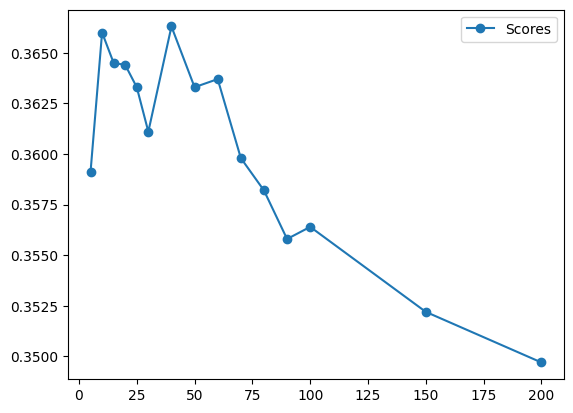

In [ ]:
import matplotlib.pyplot as plt

plt.plot( [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200], scores, '-o', label="Scores")
plt.legend()
plt.show()

In [ ]:
scores

[0.3591,
 0.366,
 0.3645,
 0.3644,
 0.3633,
 0.3611,
 0.3663,
 0.3633,
 0.3637,
 0.3598,
 0.3582,
 0.3558,
 0.3564,
 0.3522,
 0.3497]

In [ ]:
# with resnet18 from scratch
resnet18.fc = nn.Linear(512, 10)
resnet18.load_state_dict(torch.load('./resnet18.pth', map_location=torch.device(device)))

device = 'cuda'
resnet18.fc = nn.Identity()
resnet18.to(device)
resnet18.eval()

training_features = None
training_labels = None
with torch.no_grad():
   for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if training_labels is None:
        training_labels = torch.zeros(len(trainloader.dataset))
      training_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = resnet18(inputs)
      if training_features is None:
        training_features = torch.zeros(len(trainloader.dataset), features.shape[-1])
      training_features[i*batch_size: (i+1)*batch_size]=features

testing_features = None
testing_labels = None
with torch.no_grad():
   for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if testing_labels is None:
        testing_labels = torch.zeros(len(testloader.dataset))
      testing_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = resnet18(inputs)
      if testing_features is None:
        testing_features = torch.zeros(len(testloader.dataset), features.shape[-1])
      testing_features[i*batch_size: (i+1)*batch_size]=features

<ipython-input-14-4abb79aa9d04>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet18.load_state_dict(torch.load('./resnet18.pth', map_location=torch.device(device)))


In [ ]:
scores=[]
for k in [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]:
  print(k)
  tmpscore= knn(training_features, training_labels, testing_features, testing_labels, k=k)
  scores.append(tmpscore)

5
10
15
20
25
30
40
50
60
70
80
90
100
150
200


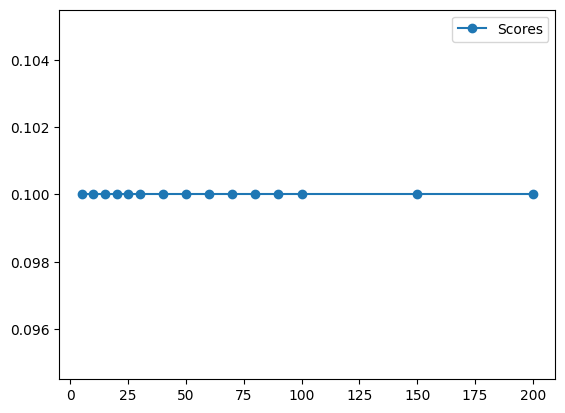

In [ ]:
import matplotlib.pyplot as plt

plt.plot( [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200], scores, '-o', label="Scores")
plt.legend()
plt.show()

In [ ]:
scores

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

In [ ]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=1000)
score

0.1003

In [ ]:
score=knn(training_features, training_labels, testing_features, testing_labels, k=5000)
score

0.6151

Pretrained models with ssl

In [ ]:
# Install timm
pip install timm

In [4]:
import timm
from PIL import Image
from urllib.request import urlopen
avail_pretrained_models = timm.list_models(pretrained=True)

In [ ]:
# check available pretrained models
avail_pretrained_models

In [5]:
# pretrained on Imagenet 1k
model = timm.create_model('resnetv2_18.ra4_e3600_r224_in1k', pretrained=True, num_classes=0)
model = model.eval()

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [8]:
# k-NN classifier
device = 'cuda'
model.fc = nn.Identity()
model.to(device)
model.eval()

training_features = None
training_labels = None
with torch.no_grad():
   for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if training_labels is None:
        training_labels = torch.zeros(len(trainloader.dataset))
      training_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = model(inputs)
      if training_features is None:
        training_features = torch.zeros(len(trainloader.dataset), features.shape[-1])
      training_features[i*batch_size: (i+1)*batch_size]=features

testing_features = None
testing_labels = None
with torch.no_grad():
   for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if testing_labels is None:
        testing_labels = torch.zeros(len(testloader.dataset))
      testing_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = model(inputs)
      if testing_features is None:
        testing_features = torch.zeros(len(testloader.dataset), features.shape[-1])
      testing_features[i*batch_size: (i+1)*batch_size]=features

In [13]:
scores=[]
for k in [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]:
  print(k)
  tmpscore= knn(training_features, training_labels, testing_features, testing_labels, k=k)
  scores.append(tmpscore)

5
10
15
20
25
30
40
50
60
70
80
90
100
150
200


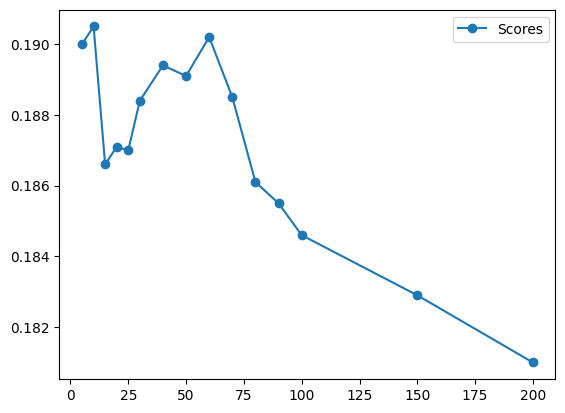

In [14]:
import matplotlib.pyplot as plt

plt.plot( [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200], scores, '-o', label="Scores")
plt.legend()
plt.show()

In [15]:
scores

[0.19,
 0.1905,
 0.1866,
 0.1871,
 0.187,
 0.1884,
 0.1894,
 0.1891,
 0.1902,
 0.1885,
 0.1861,
 0.1855,
 0.1846,
 0.1829,
 0.181]

In [14]:
# ViT, k-NN classifier
import torchvision.transforms as transforms
batch_size = 64

model = timm.create_model(
    'vit_small_patch8_224.dino',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

# Add a resize transform to the dataset
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Resize((224, 224))  # Resize images to 224x224
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Resize((224, 224))  # Resize images to 224x224
])

# Recreate the dataloaders with the new transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

print(trainset.data.shape)
print(testset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [15]:
device = 'cuda'
model.fc = nn.Identity()
model.to(device)
model.eval()

training_features = None
training_labels = None
with torch.no_grad():
   for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if training_labels is None:
        training_labels = torch.zeros(len(trainloader.dataset))
      training_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = model(inputs)
      if training_features is None:
        training_features = torch.zeros(len(trainloader.dataset), features.shape[-1])
      training_features[i*batch_size: (i+1)*batch_size]=features

testing_features = None
testing_labels = None
with torch.no_grad():
   for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if testing_labels is None:
        testing_labels = torch.zeros(len(testloader.dataset))
      testing_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = model(inputs)
      if testing_features is None:
        testing_features = torch.zeros(len(testloader.dataset), features.shape[-1])
      testing_features[i*batch_size: (i+1)*batch_size]=features

In [20]:
scores=[]
for k in [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]:
  print(k)
  tmpscore= knn(training_features, training_labels, testing_features, testing_labels, k=k)
  scores.append(tmpscore)

5
10
15
20
25
30
40
50
60
70
80
90
100
150
200


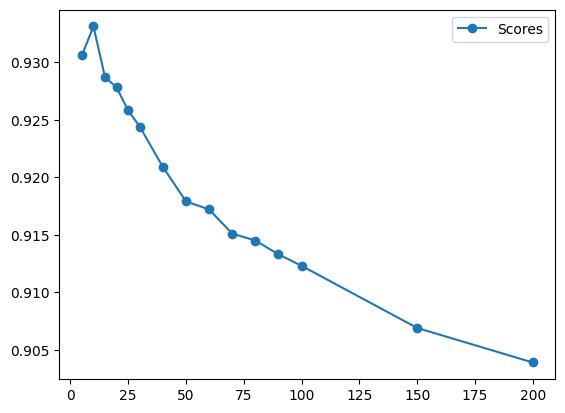

In [21]:
import matplotlib.pyplot as plt

plt.plot( [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200], scores, '-o', label="Scores")
plt.legend()
plt.show()

In [22]:
scores

[0.9306,
 0.9331,
 0.9287,
 0.9278,
 0.9258,
 0.9244,
 0.9209,
 0.9179,
 0.9172,
 0.9151,
 0.9145,
 0.9133,
 0.9123,
 0.9069,
 0.9039]

In [5]:
# Altro modello da timm
model = timm.create_model(
    'convnextv2_nano.fcmae',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear
)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/59.9M [00:00<?, ?B/s]

In [6]:
device = 'cuda'
model.fc = nn.Identity()
model.to(device)
model.eval()

training_features = None
training_labels = None
with torch.no_grad():
   for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if training_labels is None:
        training_labels = torch.zeros(len(trainloader.dataset))
      training_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = model(inputs)
      if training_features is None:
        training_features = torch.zeros(len(trainloader.dataset), features.shape[-1])
      training_features[i*batch_size: (i+1)*batch_size]=features

testing_features = None
testing_labels = None
with torch.no_grad():
   for i, data in enumerate(testloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      if testing_labels is None:
        testing_labels = torch.zeros(len(testloader.dataset))
      testing_labels[i*batch_size: (i+1)*batch_size]=labels
      inputs = inputs.to(device)

      features = model(inputs)
      if testing_features is None:
        testing_features = torch.zeros(len(testloader.dataset), features.shape[-1])
      testing_features[i*batch_size: (i+1)*batch_size]=features

In [7]:
scores=[]
for k in [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200]:
  print(k)
  tmpscore= knn(training_features, training_labels, testing_features, testing_labels, k=k)
  scores.append(tmpscore)

5
10
15
20
25
30
40
50
60
70
80
90
100
150
200


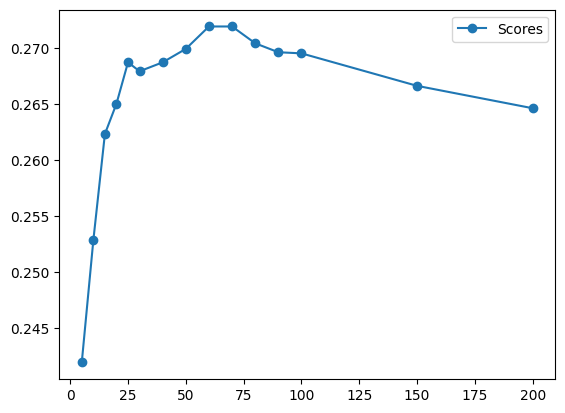

In [8]:
import matplotlib.pyplot as plt

plt.plot( [5,10,15,20,25,30,40,50,60,70,80,90,100,150,200], scores, '-o', label="Scores")
plt.legend()
plt.show()

In [9]:
scores

[0.2419,
 0.2528,
 0.2623,
 0.265,
 0.2687,
 0.2679,
 0.2687,
 0.2699,
 0.2719,
 0.2719,
 0.2704,
 0.2696,
 0.2695,
 0.2666,
 0.2646]